# Fully-unbinned analysis

This notebook checks the fully-optimal sensitivity that can be achieved by extracting the maximum possible information from each event, i.e. fully calculate the density ratio between null and alternate hypotheses.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from hstar import c6

In [2]:
# read dataset
lumi = 3000.0

# cross-section x k-factor [fb]
ggzz2e2m = c6.Sample(k=1.83, xs=1.4783394, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ2e2m_all/events.csv'))
ggzz4e = c6.Sample(k=1.83, xs=0.47412769, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ4e_all/events.csv'))
ggzz4m = c6.Sample(k=1.83, xs=0.47412769, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ4m_all/events.csv'))

ggzz2e2m.normalize(lumi)
ggzz4e.normalize(lumi)
ggzz4m.normalize(lumi)

# concatenate all events into one sample
ggzz = c6.Sample(k=1.83, xs=1.4783394+0.47412769+0.47412769, events = pd.concat([ggzz2e2m.events, ggzz4e.events, ggzz4m.events]))
ggzz.sm_msq_key = 'msq_sbi_sm'
ggzz.c6_msq_map = {
  -5 : 'msq_sbi_c6_6',
  -1 : 'msq_sbi_c6_10',
  0 : 'msq_sbi_c6_11',
  1 : 'msq_sbi_c6_12',
  5 : 'msq_sbi_c6_16'
}
ggzz.events.head()

,evtnum,p1_px,p1_py,p1_pz,p1_E,p2_px,p2_py,p2_pz,p2_E,p3_px,...,msq_sig_c6_19,msq_int_c6_19,msq_sbi_c6_19,msq_sig_c6_20,msq_int_c6_20,msq_sbi_c6_20,msq_sig_c6_21,msq_int_c6_21,msq_sbi_c6_21,wt
0,0,0.0,0.0,-195.32320,-195.32320,0.0,0.0,54.23740,-54.23740,-4.247556,...,2.051790e-10,-8.223194e-10,1.323928e-08,1.950328e-10,-8.029987e-10,1.324845e-08,1.838184e-10,-7.810834e-10,1.325915e-08,0.000615
1,1,0.0,0.0,-96.28981,-96.28981,0.0,0.0,92.20487,-92.20487,-28.016310,...,1.277027e-10,-5.537373e-10,1.386738e-08,1.219553e-10,-5.427674e-10,1.387260e-08,1.155880e-10,-5.303150e-10,1.387868e-08,0.016020
2,2,0.0,0.0,-167.67200,-167.67200,0.0,0.0,76.07164,-76.07164,-14.601730,...,5.550639e-11,-2.961814e-10,7.703880e-09,5.213969e-11,-2.869017e-10,7.709793e-09,4.845677e-11,-2.764313e-10,7.716580e-09,0.000123
3,3,0.0,0.0,-73.39238,-73.39238,0.0,0.0,386.09270,-386.09270,35.364550,...,1.944437e-12,-3.364839e-12,1.025368e-10,1.919063e-12,-3.124387e-12,1.027519e-10,1.893200e-12,-2.850493e-12,1.029999e-10,0.000452
4,4,0.0,0.0,-296.38940,-296.38940,0.0,0.0,31.99196,-31.99196,-57.723710,...,1.076842e-10,-5.071508e-10,8.909091e-09,1.026555e-10,-4.961647e-10,8.915048e-09,9.709287e-11,-4.836978e-10,8.921952e-09,0.053417


In [3]:
# clean up memory
import gc
del ggzz4e
del ggzz4m
del ggzz2e2m
gc.collect()

0

In [4]:
c6_min = -10
c6_max = 10
c6_step = 5
c6_vals = np.arange(c6_min, c6_max+c6_step, c6_step)

# Unbinned likelihood analysis

Return to the per-event likelihood:

$$ \mathcal{L} (\mathcal{D} | c_6) = \frac{}{} \prod_i^{N} p(x_i | c_6),$$

where $N$ is the total number of events observed, and $p(x_i | c_6)$ is the probability (density) of the event under some hypothesis given by value of $c_6$.
Given that the simulated dataset is that of the SM and the task is to constrain $c_6$, the best test statistic is given by the (negative log) likelihood ratio:

$$ t_\mu = - \log \left(\frac{\mathcal{L} (\mathcal{D} | c_6)}{\mathcal{L} (\mathcal{D} | c_6 = 0)} \right) = \frac{}{} \prod_i^{N} \frac{p(x_i | c_6)}{p_\mathrm{SM}(x_i)},$$

where $p_\mathrm{SM}(x_i) = p(x_i | c_6 = 0)$. Therefore, one must compute this *density ratio* 

$$OO_{\mu} = \frac{p(x_i | c_6)}{p_\mathrm{SM}(x_i)}.$$

Its computation for a set of events in a simulated dataset under different $c_6$ values is as follows:
- The matrix element (squared) factor of the event weight to have a quartic polynomial dependence on $c_6$, where $c_6 = 0$ corresponds to the SM case: $|\mathcal{M}(x_i | c_6)|^2 = |\mathcal{M}_\mathrm{SM}(x_i)|^2 \cdot f_i(c_6) = |\mathcal{M}_\mathrm{SM}(x_i)|^2 \cdot (1 + a_{1, i} c_6 + a_{2, i} c_6^2 + a_{3,i} c_6^3 + a_{4,i} c_6^4)$.
- Since the rest of the event weight from parton distribution functions and Monte Carlo sampling factorizes out without any $c_6$ dependence, its $c_6$-dependence also follows as $w_i(c_6) = w_{i,\mathrm{SM}} \times f_i(c_6)$.
- The probability of any given event is then given by $p(x_i | c_6) = w(x_i | c_6) / \sum_i w(x_i | c_6)$.
Under any given SM or $c_6$-valued scenario, the sum of the probabilities of all the events in the simulated dataset sum up to unity, $\sum_i p(x_i | c_6) = 1.$

In [5]:
c6_vals = np.linspace(-20.0, 20.0, 201)

nu_c6 = np.array(ggzz.nu(c6_vals,per_event=True))
nu_sm = np.array(ggzz.nu(per_event=True))
p_c6 = nu_c6 / ggzz.nu(c6_vals)
p_sm = nu_sm / ggzz.nu()
pratio_c6 = p_c6 / p_sm[:, np.newaxis]

nll = -2 * (ggzz.nu()) * (np.log(ggzz.nu(c6_vals)) - np.log(ggzz.nu()))
nll += +2 * (ggzz.nu(c6_vals) - ggzz.nu())
nll += -2 * np.sum(nu_sm[:, np.newaxis] * np.log(pratio_c6), axis=0)

# filter out NaN's
condition = ~np.isnan(nll)
nll = nll[condition]
c6_vals = c6_vals[condition]

/tmp/ipykernel_135920/2117909218.py:11: RuntimeWarning: invalid value encountered in log
  nll += -2 * np.sum(nu_sm[:, np.newaxis] * np.log(pratio_c6), axis=0)


1.552892010010182e-09


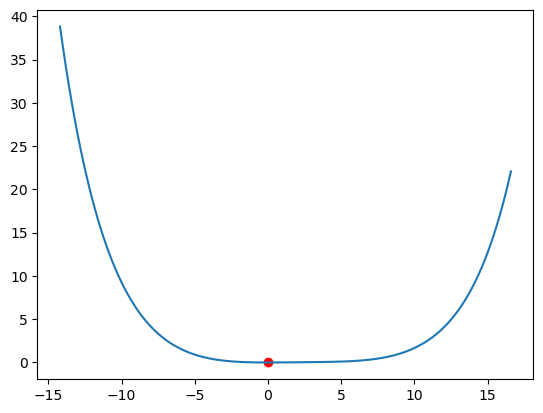

In [6]:
# find minimum
imin = np.argmin(nll)
nll_min = nll[imin]
c6_at_nll_min = c6_vals[imin]

print(nll_min)

# plot the scan + minimum
plt.plot(c6_vals, nll)
plt.scatter(c6_at_nll_min, nll_min, marker='o', color='red')
plt.show()

In [7]:
c6_vals = np.round(c6_vals, decimals = 1)
df = pd.DataFrame({'c6' : c6_vals, 'nll' : nll} )
df.to_csv('nll-full.csv', index=False)